In [1]:
# Import necessary packages
import os
import pathlib
from glob import glob
import re # Parsing info out of file names
from math import floor, ceil

import cartopy.crs as ccrs # CRSs
import earthaccess # Access NASA data from the cloud
import geopandas as gpd # Working with vector data
import pandas as pd # Aggregating and data manipulation
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
import xrspatial

c:\Users\riede\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Set up a project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat-suitability'
)

os.makedirs(data_dir, exist_ok=True)

data_dir

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability'

## 1. Define study area:

* Download the USFS National Grassland Units

* Select study sites: Caddo National Grasslands and Sheyenne National Grasslands
    * Caddo National Grasslands is mainly in Texas, USA, although a small portion of it is in Oklahoma too. It is comprised of two units: Bois d' Arc Creek Unit (13,360 acres) and Ladonia Unit (2,780 acres). It is 17,785 acres and has 3 lakes: Lake Coffee Mill (651 acres), Lake Crockett (388 acres), and Lake Fannin (45 acres). In the Caddo Grasslands you can do several recreational activities such as camping, picnicking, and fishing. The Caddo is also home to wildlife such as coyotes, waterfowl, turkey, largemouth bass, and sunfish. 
    * Sheyenne National Grasslands is in the southeastern corner of North Dakota, USA and includes 70,180 acres of public land amid 64,769 acres of private land. Similar to Caddo National Grasslands, you can camp, hike, hunt, and backpack as well as other recreational activities. This tallgrass prairie is home to prairie chickens, the Dakota skipper (a small butterfly), the Regal Fritillary (another type of butterfly), ferns, and the western prairie fringed orchid. 

* Citations:
    1. “Caddo-LBJ National Grasslands.” National Forests and Grasslands in Texas, U.S. Forest Service, U.S. Department of Agriculture, www.fs.usda.gov/detail/texas/about-forest/districts/?cid=fswdev3_008440. Accessed 2 Dec. 2024. 
    2. Caddo National Grasslands WMA, Texas Parks and Wildlife Department, tpwd.texas.gov/huntwild/hunt/wma/find_a_wma/list/?id=4. Accessed 2 Dec. 2024.
    3. “Sheyenne National Grassland.” Dakota Prairie Grasslands, U.S. Forest Service, U.S. Department of Agriculture, www.fs.usda.gov/recarea/dpg/recarea/?recid=79470. Accessed 2 Dec. 2024. 


,OBJECTID,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE.AREA,SHAPE.LEN,geometry
0,187245,281771010328,Fort Pierre National Grassland,209044.225,0.095149,1.455518,"POLYGON ((-100.0841 44.28163, -100.0841 44.278..."
1,187246,295507010328,Butte Valley National Grassland,19489.170,0.008557,0.853736,"MULTIPOLYGON (((-121.99601 41.84049, -121.9960..."
2,187247,295508010328,Kiowa National Grassland,144281.321,0.058543,9.858642,"MULTIPOLYGON (((-104.30415 36.08063, -104.3041..."
3,187248,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31082 46.51457, -97.3056 4..."
4,187249,295510010328,Cedar River National Grassland,6717.517,0.003157,0.999947,"MULTIPOLYGON (((-101.82222 45.95897, -101.8170..."
5,187250,295511010328,Black Kettle National Grassland,33103.349,0.013340,4.561060,"MULTIPOLYGON (((-99.9166 35.71892, -99.91662 3..."
6,187251,295512010328,Rita Blanca National Grassland,94127.091,0.038271,6.652113,"MULTIPOLYGON (((-102.62994 36.44073, -102.6298..."
7,187252,295513010328,Thunder Basin National Grassland,626249.208,0.282888,44.088050,"MULTIPOLYGON (((-105.46006 43.31909, -105.4601..."
8,187253,295514010328,McClellan Creek National Grassland,1401.715,0.000562,0.115902,"POLYGON ((-100.86004 35.20951, -100.86009 35.2..."
9,187254,295515010328,Caddo National Grassland,68479.549,0.026940,1.159342,"MULTIPOLYGON (((-95.85493 33.79814, -95.85495 ..."


<Axes: >

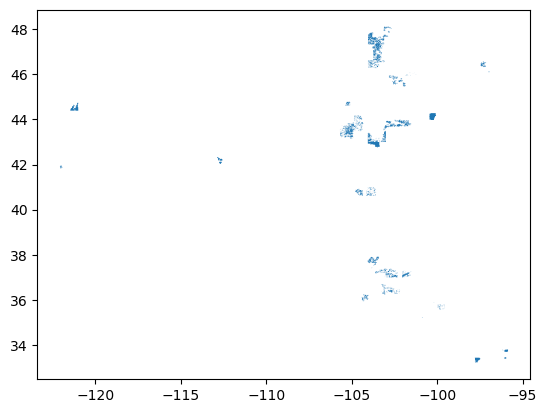

In [3]:
# Set up the grassland URL
grasslands_url = ("https://apps.fs.usda.gov/arcx/rest/services"
    "/EDW/EDW_NationalGrassland_01/MapServer/0"
    "/query?where=1%3D1&outFields=*&geometry=&geometry"
    "Type=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=4326&f=json")

# Set up a path to save the data on your machine
grasslands_dir = os.path.join(data_dir, 'grasslands_dir')

# Make the grasslands directory
os.makedirs(grasslands_dir, exist_ok=True)

# Join grasslands shapefile path
grasslands_path = os.path.join(grasslands_dir, 'S_USA.NationalGrassland.shp')

# Only download once
if not os.path.exists(grasslands_path):
    grasslands_gdf = gpd.read_file(grasslands_url)
    grasslands_gdf.to_file(grasslands_path)

# Check that the URL is correct
grasslands_gdf = gpd.read_file(grasslands_path)

# Display grasslands_gdf and plot grasslands to check download
display(grasslands_gdf)
grasslands_gdf.plot()

,OBJECTID,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE.AREA,SHAPE.LEN,geometry
3,187248,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31082 46.51457, -97.3056 4..."


<Axes: >

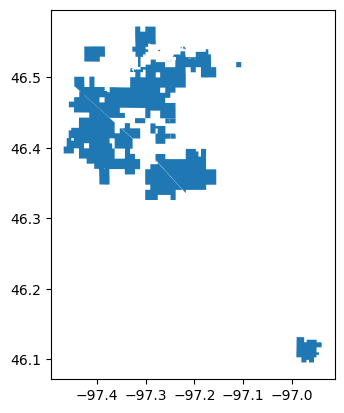

In [4]:
# Isolate Sheyenne National Grasslands from the grasslands_gdf
sheyenne_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN']=='Sheyenne National Grassland']
display(sheyenne_grasslands_gdf)
sheyenne_grasslands_gdf.plot()

,OBJECTID,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE.AREA,SHAPE.LEN,geometry
9,187254,295515010328,Caddo National Grassland,68479.549,0.02694,1.159342,"MULTIPOLYGON (((-95.85493 33.79814, -95.85495 ..."


<Axes: >

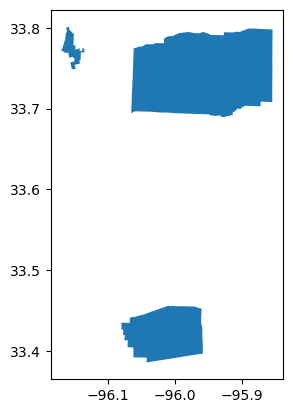

In [5]:
# Isolate Caddo National Grasslands from the grasslands_gdf
caddo_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN']=='Caddo National Grassland']
display(caddo_grasslands_gdf)
caddo_grasslands_gdf.plot()

## 2. Load in soil data

For each grassland, download at least one soil variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) as raster data. 
    
* [Further POLARIS info](https://pubs.usgs.gov/publication/70170912)

* I'll look at soil pH, specifically the mean soil pH of 30x30 meter pieces of land for the 60-100 cm depth. *S. nutans* prefers a soil pH of [4.8 to 8.0](https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf) and has a minimum [root depth of 24 inches, or about 61 cm](https://plants.sc.egov.usda.gov/plant-profile/SONU2/characteristics).

* Depths of the POLARIS data set is in cm.

* Need to use rioxarray to import

### 2a. Load in Sheyenne soil data

array([-97.46881033,  46.09534316, -96.93854828,  46.57204154])

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon{min_lon}{max_lon}.tif'

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif']

OPENED
CROPPED
OPENED
CROPPED


[<xarray.DataArray (y: 1717, x: 1688)> Size: 12MB
 [2898296 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 14kB -97.47 -97.47 -97.47 ... -97.0 -97.0 -97.0
   * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 1717, x: 222)> Size: 2MB
 [381174 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 2kB -97.0 -97.0 -97.0 ... -96.94 -96.94 -96.94
   * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area]

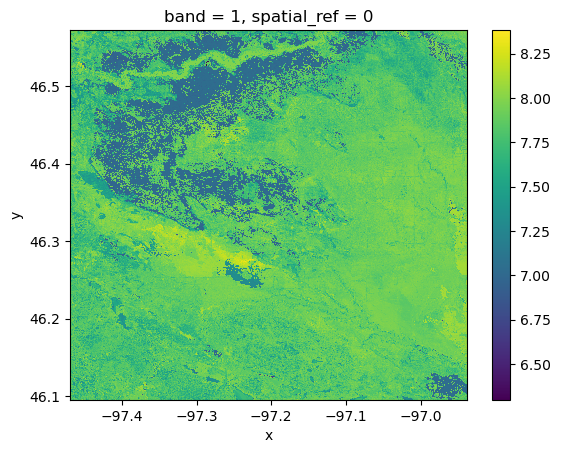

In [6]:
# Define Sheyenne bounds
sheyenne_bounds = s_bounds_min_lon, s_bounds_min_lat, s_bounds_max_lon, s_bounds_max_lat = (
    sheyenne_grasslands_gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
display(sheyenne_bounds)

#  Define the sheyenne download URL template for the soil data
sheyenne_soil_template_url = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat4647_lon{min_lon}{max_lon}.tif")
display(sheyenne_soil_template_url)

# List out all the Sheyenne soil files we will need to download
sheyenne_soil_url_list = []
for min_lon in range(floor(s_bounds_min_lon), ceil(s_bounds_max_lon)):
    for min_lat in range(floor(s_bounds_min_lat), ceil(s_bounds_max_lat)):
        soil_url = sheyenne_soil_template_url.format(
            min_lon=min_lon, max_lon=min_lon+1)
        sheyenne_soil_url_list.append(soil_url)
display(sheyenne_soil_url_list)

sheyenne_das = []
# Loop through each of the soil files
for i in sheyenne_soil_url_list:
    # Download raster data

    # Unzip the raster data

    # Extract metadata from the file name

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask and scale and squeeze w/ .tif files
    soil_da = rxr.open_rasterio(
        i,
        mask_and_scale=True
        ).squeeze()
    print('OPENED')
    # sheyenne_das.append(soil_da)
    # Make sure that the CRS matches between the vector and raster data, this could also be done up above the output_da_list is defined
    

    # Crop the raster data
    cropped_da = soil_da.rio.clip_box(*sheyenne_bounds)
    sheyenne_das.append(cropped_da)
    print('CROPPED')

display(sheyenne_das)

# Merge tiles
sheyenne_merged_das = merge_arrays(sheyenne_das)
sheyenne_merged_das.plot()


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

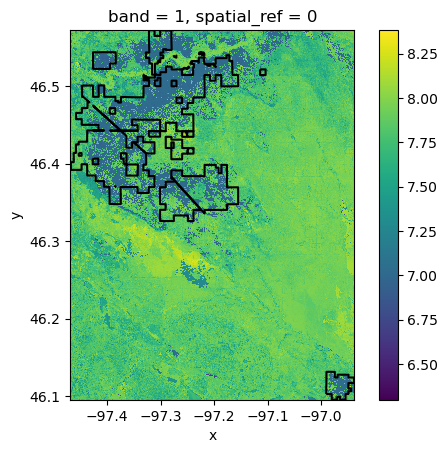

In [7]:
sheyenne_merged_das.plot()

# Plot Sheyenne National Grasslands on sheyenne_soil_da
sheyenne_grasslands_gdf.to_crs(sheyenne_merged_das.rio.crs).boundary.plot(ax = plt.gca(), color='black')

### 2b. Load Caddo soil data

array([-96.16923458,  33.38543577, -95.85492674,  33.80186199])

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon{min_lon}{max_lon}.tif'

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif']

OPENED
CROPPED
OPENED
CROPPED


[<xarray.DataArray (y: 1500, x: 610)> Size: 4MB
 [915000 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 5kB -96.17 -96.17 -96.17 ... -96.0 -96.0 -96.0
   * y            (y) float64 12kB 33.8 33.8 33.8 33.8 ... 33.39 33.39 33.39
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area,
 <xarray.DataArray (y: 1500, x: 523)> Size: 3MB
 [784500 values with dtype=float32]
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 4kB -96.0 -96.0 -96.0 ... -95.86 -95.86 -95.85
   * y            (y) float64 12kB 33.8 33.8 33.8 33.8 ... 33.39 33.39 33.39
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area]

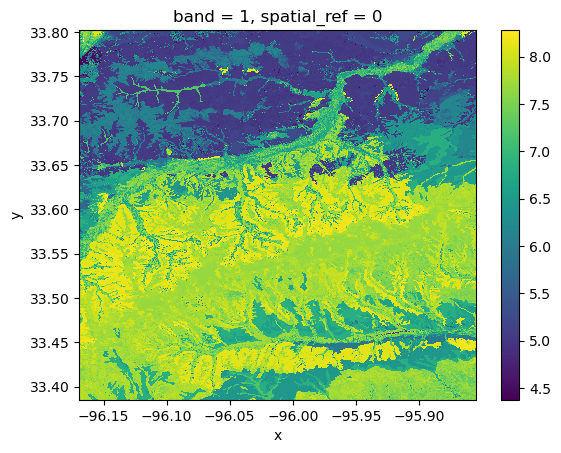

In [8]:
# Define Caddo bounds
caddo_bounds = c_bounds_min_lon, c_bounds_min_lat, c_bounds_max_lon, c_bounds_max_lat = (
    caddo_grasslands_gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
display(caddo_bounds)

#  Define the Caddo download URL template for the soil data
caddo_soil_template_url = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat3334_lon{min_lon}{max_lon}.tif")
display(caddo_soil_template_url)

# List out all the Caddo soil files we will need to download
caddo_soil_url_list = []
for min_lon in range(floor(c_bounds_min_lon), ceil(c_bounds_max_lon)):
    for min_lat in range(floor(c_bounds_min_lat), ceil(c_bounds_max_lat)):
        soil_url = caddo_soil_template_url.format(
            min_lon=min_lon, max_lon=min_lon+1)
        caddo_soil_url_list.append(soil_url)
display(caddo_soil_url_list)

caddo_das = []
# Loop through each of the soil files
for i in caddo_soil_url_list:
    # Download raster data

    # Unzip the raster data

    # Extract metadata from the file name

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask and scale and squeeze w/ .tif files
    soil_da = rxr.open_rasterio(
        i,
        mask_and_scale=True
        ).squeeze()
    print('OPENED')
    # sheyenne_das.append(soil_da)
    # Make sure that the CRS matches between the vector and raster data, this could also be done up above the output_da_list is defined
    
    # Crop the raster data
    cropped_da = soil_da.rio.clip_box(*caddo_bounds)
    caddo_das.append(cropped_da)
    print('CROPPED')

display(caddo_das)

# Merge tiles
caddo_merged_das = merge_arrays(caddo_das)
caddo_merged_das.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

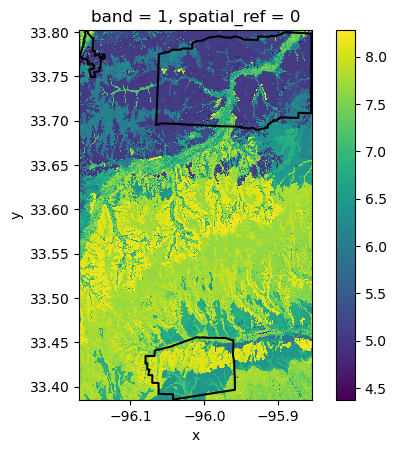

In [9]:
caddo_merged_das.plot()

# Plot Sheyenne National Grasslands on sheyenne_soil_da
caddo_grasslands_gdf.to_crs(caddo_merged_das.rio.crs).boundary.plot(ax = plt.gca(), color='black')

### 2c. Trying to get one big loop to work for soil data....

In [10]:
# Loop through bounds of Caddo and Sheyenne

# c_s_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN'].isin(['Sheyenne National Grassland', 'Caddo National Grassland'])]
c_s_grasslands_gdf = [caddo_grasslands_gdf, sheyenne_grasslands_gdf]
c_s_grasslands_gdf

bounds = []
soil_urls = []
for gdf in c_s_grasslands_gdf:
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
    bounds.append((bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat))
    
# Try doing bound loop and soil_urls loop separate?

    bounds_df = pd.DataFrame(bounds).rename(
        index={0: 'Caddo Bounds', 1: 'Sheyenne Bounds'},
        columns={0: 'min_lon', 1: 'min_lat', 2: 'max_lon', 3: 'max_lat'})
    

    #  Define the Caddo download URL template for the soil data
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
                "v1.0"
                "/ph"
                "/mean"
                "/60_100"
                "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
    #display(soil_url_template)

    #soil_urls = []
    for i in bounds_df.groupby(level=0):
        #print(i)
        for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
            for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
                soil_url = soil_url_template.format(
                    min_lat=min_lat, max_lat=min_lat+1,
                    min_lon=min_lon, max_lon=min_lon+1)
                soil_urls.append(soil_url)
    #display(soil_urls)
display(bounds)
display(bounds_df)
soil_urls

[(np.float64(-96.1692345765796),
  np.float64(33.38543577462093),
  np.float64(-95.85492673757102),
  np.float64(33.80186198772292)),
 (np.float64(-97.46881033436894),
  np.float64(46.0953431579286),
  np.float64(-96.93854828332353),
  np.float64(46.57204154162918))]

,min_lon,min_lat,max_lon,max_lat
Caddo Bounds,-96.169235,33.385436,-95.854927,33.801862
Sheyenne Bounds,-97.468810,46.095343,-96.938548,46.572042


['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-97-96.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3334_lon-96-95.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-98-97.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat4647_lon-97-96.tif']

In [11]:
# Loop through bounds of Caddo and Sheyenne

# c_s_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN'].isin(['Sheyenne National Grassland', 'Caddo National Grassland'])]
c_s_grasslands_gdf = [caddo_grasslands_gdf, sheyenne_grasslands_gdf]
c_s_grasslands_gdf

bounds = []
for gdf in c_s_grasslands_gdf:
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)
    bounds.append((bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat))

bounds_df = pd.DataFrame(bounds).rename(
    index={0: 'Caddo Bounds', 1: 'Sheyenne Bounds'},
    columns={0: 'min_lon', 1: 'min_lat', 2: 'max_lon', 3: 'max_lat'})

bounds_df
    

#  Define the Caddo download URL template for the soil data
soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
            "v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
display(soil_url_template)

soil_urls = []
for row in bounds_df.groupby(level=0):
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
         print(min_lon)
         for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
             print(min_lat)
    #         soil_url = soil_url_template.format(
    #             min_lat=min_lat, max_lat=min_lat+1,
    #             min_lon=min_lon, max_lon=min_lon+1)
    #         soil_urls.append(soil_url)
    #display(soil_urls)
# display(bounds)
# display(bounds_df)
soil_urls



# List out all the Caddo soil files we will need to download
# caddo_soil_url_list = []
# for min_lon in range(floor(c_bounds_min_lon), ceil(c_bounds_max_lon)):
#     for min_lat in range(floor(c_bounds_min_lat), ceil(c_bounds_max_lat)):
#         soil_url = caddo_soil_template_url.format(
#             min_lon=min_lon, max_lon=min_lon+1)
#         caddo_soil_url_list.append(soil_url)
# display(caddo_soil_url_list)

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

-98
46
-97
46
-98
46
-97
46


[]

## 3. Load in elevation data for each grassland from the SRTM as raster data.

### 3a. Download Sheyenne elevation data

In [12]:
sheyenne_elevation_dir = os.path.join(data_dir, 'sheyenne-elevation-srtm')

os.makedirs(sheyenne_elevation_dir, exist_ok=True)

sheyenne_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm'

In [13]:
earthaccess.login()

In [14]:
# Search earthaccess datasets for SRTM
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

In [16]:
# Sheyenne data search
srtm_pattern = os.path.join(sheyenne_elevation_dir, '*.hgt.zip')
# Define sheyenne bounds
sheyenne_elev_bounds = tuple(sheyenne_grasslands_gdf.total_bounds)

if glob(srtm_pattern):
    # Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
    srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=sheyenne_elev_bounds
    )
    # Download SRTM files
    srtm_results = earthaccess.download(srtm_search, sheyenne_elevation_dir)

srtm_results

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm\\N46W097.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm\\N46W098.SRTMGL1.hgt.zip']

In [17]:
# Check sheyenne_srtm_results download
# srtm dataset files are geotiffs but they instead have a .hgt tag (height)
# results are also .zip files
srtm_results

['C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm\\N46W097.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\sheyenne-elevation-srtm\\N46W098.SRTMGL1.hgt.zip']

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

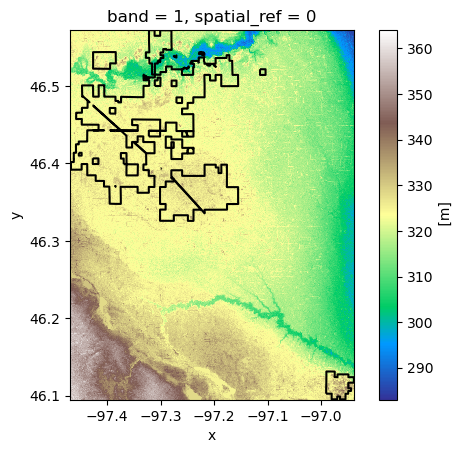

In [18]:
# Open Sheyenne SRTM files
srtm_da_list = []
for srtm_path in glob(srtm_pattern):
    # Open files and put them in a data array
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop data arrays
    srtm_cropped_da = tile_da.rio.clip_box(*sheyenne_elev_bounds)
    srtm_da_list.append(srtm_cropped_da)
    
# Merge tiles
srtm_da = merge_arrays(srtm_da_list)

# Check SRTM data w/ Sheyenne plotted on top
srtm_da.plot(cmap='terrain')

sheyenne_grasslands_gdf.boundary.plot(ax = plt.gca(), color='black')

### 3b. Download Caddo elevation data

In [19]:
caddo_elevation_dir = os.path.join(data_dir, 'caddo-elevation-srtm')

os.makedirs(caddo_elevation_dir, exist_ok=True)

caddo_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm'

In [21]:
# Caddo data search
caddo_srtm_pattern = os.path.join(caddo_elevation_dir, '*.hgt.zip')

# Define Caddo bounds
caddo_elev_bounds = tuple(caddo_grasslands_gdf.total_bounds)

if glob(caddo_srtm_pattern):
    caddo_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=caddo_elev_bounds
    )
    # Download SRTM files
    caddo_srtm_results = earthaccess.download(caddo_srtm_search, caddo_elevation_dir)

caddo_srtm_results

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm\\N33W097.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm\\N33W096.SRTMGL1.hgt.zip']

In [22]:
# Check caddo_srtm_results download
# srtm dataset files are geotiffs but they instead have a .hgt tag (height)
# results are also .zip files
caddo_srtm_results

['C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm\\N33W097.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\caddo-elevation-srtm\\N33W096.SRTMGL1.hgt.zip']

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

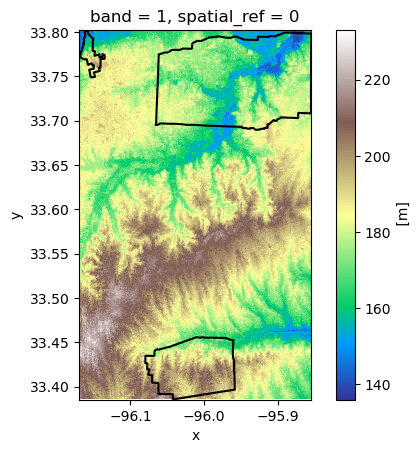

In [23]:
# Open Caddo SRTM files
caddo_srtm_da_list = []
for srtm_path in glob(caddo_srtm_pattern):
    # Open files and put them in a data array
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop data arrays
    srtm_cropped_da = tile_da.rio.clip_box(*caddo_elev_bounds)
    caddo_srtm_da_list.append(srtm_cropped_da)
caddo_srtm_da_list
# Merge tiles
caddo_srtm_da = merge_arrays(caddo_srtm_da_list)

# Check SRTM data w/ Caddo plotted on top
caddo_srtm_da.plot(cmap='terrain')

caddo_grasslands_gdf.boundary.plot(ax = plt.gca(), color='black')

### 3c. Calculate Sheyenne aspect
[Aspect info:](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA) Direction of the aspect can be determined by its value:
* From 0 to 22.5: North
* From 22.5 to 67.5: Northeast
* From 67.5 to 112.5: East
* From 112.5 to 157.5: Southeast
* From 157.5 to 202.5: South
* From 202.5 to 247.5: Southwest
* From 247.5 to 292.5: West
* From 292.5 to 337.5: Northwest
* From 337.5 to 360: North
* Values of -1 are flat areas

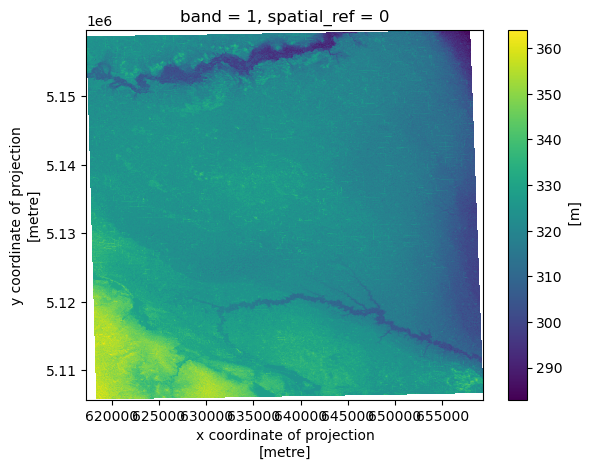

In [24]:
# Reproject srtm_da
# Have to use rioxarray to handle coordinates of data array
utm14_epsg = 32614
sheyenne_srtm_proj_da = srtm_da.rio.reproject(utm14_epsg)
sheyenne_srtm_proj_da.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

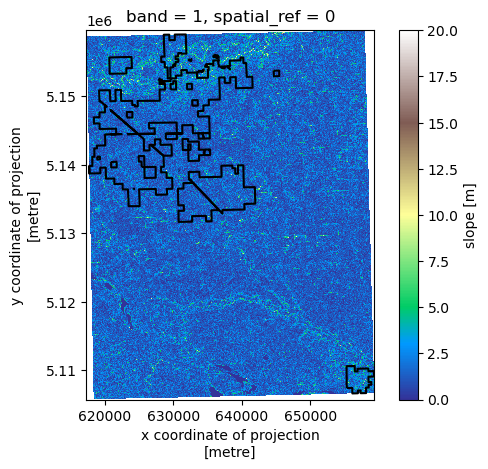

In [25]:
# Calculate Sheyenne slope
sheyenne_slope_da = xrspatial.slope(sheyenne_srtm_proj_da)
sheyenne_slope_da.plot(cmap='terrain')
sheyenne_grasslands_gdf.to_crs(utm14_epsg).boundary.plot(ax = plt.gca(), color='black')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

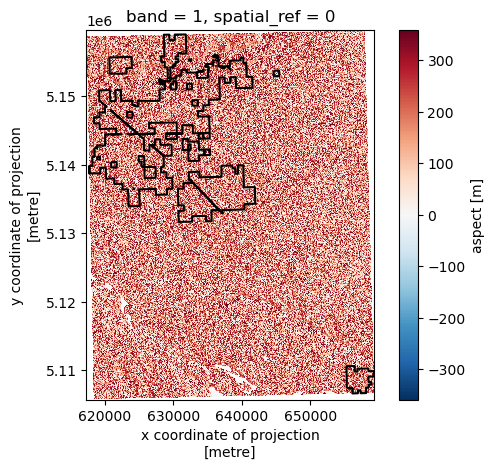

In [26]:
# Calculate Sheyenne aspect
sheyenne_aspect_da = xrspatial.aspect(sheyenne_srtm_proj_da)
sheyenne_aspect_da.plot()
sheyenne_grasslands_gdf.to_crs(utm14_epsg).boundary.plot(ax = plt.gca(), color='black')

### 3d. Calculate Caddo aspect

## Load in climate data

For each grassland: Download one climate variable from the MACAv2 THREDDS data server as raster data.

## Derive a topographic variable

For each grassland: calculate at least one derived topographic variable.

In [30]:
# Make sure you're in a crs with units of meters, like UTM, not degrees

<Axes: >

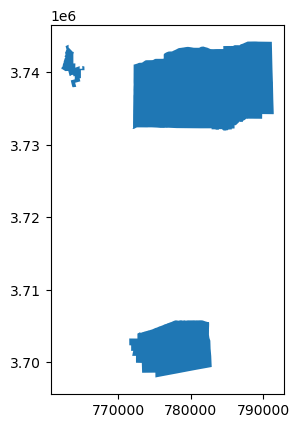

In [ ]:
reproj_gdf = caddo_grasslands_gdf.to_crs(ccrs.UTM(14))
reproj_gdf.plot()

In [ ]:
sheyenne_bounds = s_bounds_min_lon, s_bounds_min_lat, s_bounds_max_lon, s_bounds_max_lat = (
    sheyenne_grasslands_gdf
    #.to_crs(ccrs.UTM(zone=14))
    .total_bounds)

sheyenne_bounds

array([-97.46881033,  46.09534316, -96.93854828,  46.57204154])

In [ ]:
sheyenne_grasslands_gdf.estimate_utm_crs()

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Harmonize data

In [31]:
# possibly use ds.rio.reproject_match() method from rioxarray

# Build fuzzy logic model

## Create at least one figure for each grassland/climate scenario combination

In [32]:
# EXAMPLE of a for loop and accumulating the answers

a_list = [1, 2, 3, 4]

#w/o this accumulator list, when we run the for loop below w/o the prints, we just see 16
squared_number_list = []

for number in a_list:
    #print(number)
    squared_number = number**2
    #print(squared_number)
    squared_number_list.append(squared_number)

print(squared_number)
squared_number_list

16


[1, 4, 9, 16]